# Grover's Algorithm with hierarcqal


In [1]:
#!pip install qiskit-aer


In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from hierarqcal import Qinit, Qmask, Qunmask, Qmotif, Qunitary, Qpivot, Qcycle

mpl_backend = mpl.get_backend()


## Background

Imagine someone hands you a definition of a word. They then ask you to use a dictionary to find the word that has a definition that exactly matches the given definition. If your dictionary contains $N$ words, on average you will need to check (query) $N/2$ times whether a word's definition exactly matches the given definition before you can expect to find an exact match. This is intuitively correct since sometimes you will be lucky and find the word immediately, while other times you will need to search through the entire dictionary before you find the word you seek. 

This is a typical example of a search of an unstructured database. In our example a dictionary, while clearly structured alphabetically, is not structured with respect to the definitions it contains. Grover's algorithm is a quantum algorithm that provides a speed-up with respect to the number of steps needed, allowing one to find the sought entry in order $\sqrt{N}$ queries.

### The algorithm

Grover's algorithm provides an optimal method to amplify the amplitude of a specific state. This specific state is usually referred to as the *target state* which we label  $T$. The algorithm requires an oracle, that is a "black-box" with the ability to change the sign of the amplitude of the target state. This processes is commonly described as *marking* the target. 

Grover's algorithm works in two steps:

Step 1: Apply the oracle. 

Step 2: Reflect in a hyperplane orthogonal to some state $\psi$. 

It turns out that step 1 and 2 are in fact the same type of operation, namely a reflection. Reflecting a vector is nothing other than changing the sign of the component of the vector that is parallel to the normal to the (hyper)plane of reflection, while doing nothing to all other components of the vector. Step 1 is therefore nothing other than a reflection in the hyperplane orthogonal to the target state $T$. 

A reflection in the hyperplane orthogonal to a vector $\hat{n}$ is given in Dirac notation by
$$U_{\text{reflect}} = \mathbb{I} - 2|\hat{n}  \rangle\langle \hat{n} |$$
where $|\hat{n}\rangle$ is the state associated with the normal vector $\hat{n}$.

We shall see that the algorithm performs optimally if $\psi$,  $T$ and the initial state of the system all lie in the same plane.

### *Side note on reflections* 
In descriptions of Grover's algorithm the second step is commonly characterized as a reflection *across a state* in the plane, with this state taken to be the equal superposition of all computational basis states. A reflection across a state can be written as
$$V = - \mathbb{I} + 2|\hat{r}  \rangle\langle \hat{r} |$$
where $\hat{r}$ is the state across which we reflect. It is straightforward to check that $V$ can also be written as
$$V = - \big(\mathbb{I} - 2|\hat{r}_\perp  \rangle\langle \hat{r}_\perp | \big)$$
where $\hat{r}_\perp$ is a vector perpendicular to $\hat{r}$. The above equality shows that any reflection *across a state $\hat{r}$ in a hyperplane* can be reformulated at a reflection *in the hyperplane orthogonal to a state* $\hat{r}_\perp$.
 
Since $\psi$ is some arbitrary state, $V$ and $U_{\text{reflect}}$ differ only by a global phase factor.


### Evolution according to Grover

The complete action of Grover's algorithm can be described as a rotation in a fixed plane by a fixed angle. 

Assuming that we started in some state $\phi$, which we denote in Dirac notation as $|\phi\rangle$, one iteration of Grover's algorithm transforms the initial state as follows
$$|\phi\rangle \rightarrow (\mathbb{I} - 2|\psi \rangle\langle \psi|)(\mathbb{I} - 2|T \rangle\langle T|)|\phi\rangle\,.$$

One can visualize this process by first noticing that $|\phi\rangle$ can be separated into two components: A component lying in the plane spanned by $|T\rangle$ and $|\psi\rangle$ and a component orthogonal to this plane. In this way we can visualize the process in three dimensions, despite the fact that the process occurs in a high-dimensional space.

Note that the component of $\phi$ orthogonal to the plane spanned by $T$ and $\psi$ is an eigenstate of the transformation. It therefore represents a portion of the initial state that is inaccessible to the algorithm. Hence, the algorithm performs optimally if $\psi$,  $T$ and $\phi$ all lie in the same plane, as mentioned earlier. The algorithm completely breaks down if $\phi$ is orthogonal to the plane spanned by $\psi$ and $T$.

<img src="./grover.gif" alt="Grover animation" width="400"/>

The diagram above depicts one iteration of Grover's algorithm. The states $\psi$ and $T$ are depicted as lying in the plane of your screen, while the initial state $\phi$ lies somewhere outside of this plane. The components of $\phi$ lying inside and outside of the plane spanned by $T$ and $\psi$ are shown as dashed vectors. 

The first set of green arrows show step 1, the action of the oracle: the component of the initial state parallel to the target is *marked* with a $\pi$ phase. 

The second set of green arrows show step 2: the intermediate state is reflected in the hyperplane orthogonal to the state $\psi$. 

The final frame shows the initial and final positions of $\phi$. 

#### *How big is the angle of rotation?*
Since the target is in principle unknown, it is reasonable to assume that the initial state only contains some small component of the target state. For the same reason, $\psi$ (or equivalently the state orthogonal to $\psi$ in the plane spanned by $\psi$ and $T$ see *side note*) is usually chosen as an equal superposition of all computational basis states. This gives the best "coverage" for all possible target states. (It is left as an exercise to the reader to convince yourself that the algorithm fails to amplify the target state if $\psi$ and $T$ are parallel or orthogonal.) Hence, if the computational basis (i.e. the search space) is large, the angle of rotation is in general small, which for ease of depiction is not the case in the above animation. We can now update our remark on the evolution according to Grover's algorithm to:

**Grover's algorithm can be described as a rotation in a fixed plane by a fixed, usually small, angle.**

### Knowing when to stop

The target state is, in general, not an eigenstate of the transformation 
$$U_G = (\mathbb{I} - 2|\psi \rangle\langle \psi|)(\mathbb{I} - 2|T \rangle\langle T|)\,.$$
The probability of measuring $T$ as a function of the number of iterations of the algorithm is given by
$$P_T(n) = |\langle T|U_G^n|\phi\rangle|^2 = \langle \phi_\||\phi_\|\rangle \sin^2(\theta_0 + 2n\theta)$$
where $\cos(\theta) = |\langle T|\psi\rangle|$, $\sin(\theta_0) = \frac{|\langle T|\phi_\|\rangle|}{\sqrt{\langle  \phi_\| | \phi_\|\rangle}}$ and $|\phi_\| \rangle = |T\rangle\langle T|\phi\rangle + \frac{1}{1-|\langle T|\psi\rangle|^2} (\mathbb{I} - |T\rangle\langle T|)|\psi \rangle\langle\psi| (\mathbb{I} - |T\rangle\langle T|)|\phi\rangle$ is the non-normalized projection of $\phi$ into the plane spanned by $T$ and $\psi$.

The probability $P_T(n)$ oscillates periodically as a function of $n$ and we can compute the optimal number of iterations required to maximize the probability of measuring the target state. In practice, for large Hilbert spaces, we can estimate the optimal number of iterations to be $\sqrt{N}$, if $\psi$, $T$, $\phi$ $\in \otimes^n \mathcal{H}_2$, i.e. are $n$ qubit states, where $n = \log_2 N$ is large.

The angle $\theta$ is in fact the angle of rotation which characterizes Grover's algorithm and the evolution as a function as the number of iterations $n$ can be written as 
$$|\phi(n)\rangle = U_G^n|\phi\rangle  = \sqrt{\langle \phi_\||\phi_\|\rangle} \big(\sin(\theta_0 + 2n\theta) |T\rangle + \cos(\theta_0 + 2n\theta) |T_\perp\rangle\big) + |\phi_R\rangle\,,$$
where  $ |T_\perp\rangle = (\mathbb{I} - |T\rangle\langle T|)|\psi \rangle/\sqrt{1-|\langle T|\psi\rangle|^2}$ is the state orthogonal to the target in the plane spanned by $T$ and $\psi$ and $|\phi_R\rangle = |\phi\rangle - |\phi_\|\rangle$ is the "rest" state that contains the component of $\phi$ orthogonal to this plane.




## Grover's algorithm with Hierarqcal

In order to simulate Grover's algorithm we make the further simplification
$$U_G = (\mathbb{I} - 2|\psi \rangle\langle \psi|)(\mathbb{I} - 2|T \rangle\langle T|) = U_\psi (\mathbb{I} - 2|0 \rangle\langle 0|)U_\psi^\dagger U_T(\mathbb{I} - 2|0 \rangle\langle 0|) U_T^\dagger \,.$$
For the purposes of this tutorial we have to construct the circuit that implements the oracle, but in practice the oracle can be imagined as some black-box we can pass our qubits to, without knowing it's inner workings. 

In order to construct the quantum circuit to perform Grover's algorithm we need only three operators $U_\psi$ which prepares $\psi$, $U_T$ which encodes the target state and $\mathbb{I} - 2|0 \rangle\langle 0|$ which is nothing other than a rotated multi-controlled $Z$ gate.

In this tutorial we implement the multi-controlled $Z$ gate using a series of Toffoli gates and some additional ancillary qubits. Other implementations are possible but here we made the arbitrary choice to opt for the implementation with a smaller circuit depth. 

### Choose the number of qubits

In [3]:
n = 7


### Choose target state

Here we generate a random bit string to determine the target but you can select any target provided that the string that defines it is of length $n$, to avoid unexpected behavior.

In [4]:
random_int = np.random.randint(0, 2**n)
target_string = bin(random_int)[2:].zfill(n)


## Create the Grover circuit

Our basic building blocks are:

In [5]:
# Hadamard
H = Qunitary("H()^0")
# Pauli X
X = Qunitary("X()^0")
# Controlled phase
Cp = lambda x: Qunitary("cp(x)^01", symbols=[x], arity=2)
# Controlled not
Cnot = Qunitary("cnot()^01", symbols=[], arity=2)


Here we take the state $\psi$ to be the usual equal superposition of all computational basis states. The unitary $U_T$ is defined by the binary representation of the target state.

In [6]:
# Unitary to prepare the state |psi>
U_psi = Qcycle(mapping=H)
# Unitary to prepare the target state |T>
U_T = Qpivot(mapping=X, global_pattern=target_string[::-1])


### Multi-controlled Z

The backbone of a multi-controlled gate is the Toffoli gate.

In [7]:
# Toffoli gate
U_toffoli = Qinit(3)
U_toffoli += Qpivot(mapping=H, global_pattern="*1")
U_toffoli += Qpivot(mapping=Cp(-np.pi / 2), global_pattern="*1", merge_within="01")
U_toffoli += Qmotif(E=[(0, 1)], mapping=Cnot)
U_toffoli += Qmotif(E=[(1, 2)], mapping=Cp(np.pi / 2))
U_toffoli += Qmotif(E=[(0, 1)], mapping=Cnot)
U_toffoli += Qpivot(mapping=H, global_pattern="*1")


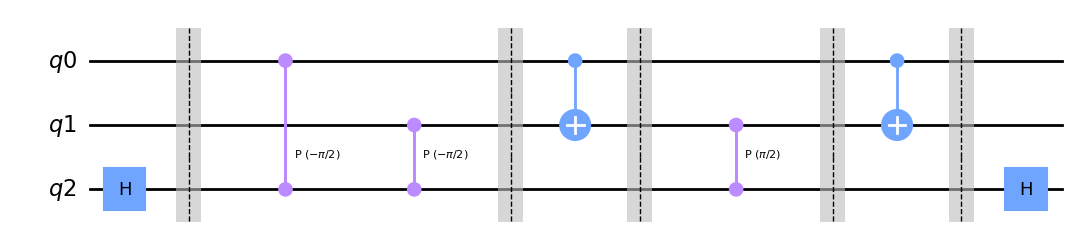

In [8]:
tofolli = U_toffoli(backend="qiskit", barriers=True)
tofolli.draw("mpl", fold=50)


We will periodically mask and unmask the ancillary states from the circuit to make them unaccessible or assessable as needed. 

In [9]:
# Mask ancillary qubits
ancilla_str = "0" + "01" * (n - 3) + "00"
maskAncillas = Qmask(ancilla_str)


In [10]:
# Multicontrolled Z gate
# The multi-controlled gate use the ancillary qubits so we first unmask them to make them available
multiCZ = Qunmask("previous")
# In order to convert what is a multi-controlled X gate to a multi-controlled Z gate apply H on the last qubit on either side
multiCZ += Qpivot(mapping=H, global_pattern="*1")
# Apply the Toffoli gate sequentially to each pair of qubits with intermediate steps stored on the ancillary qubits
multiCZ += Qcycle(mapping=U_toffoli, step=2, boundary="open")
# The final qubit is not an ancillary qubit, so we need to unmask it
multiCZ += Qmask("*1")
# Apply the same sequence of Toffoli gates in reverse order in order to reset the ancillary qubits to 0
multiCZ += Qcycle(mapping=U_toffoli, step=2, boundary="open", edge_order=[-1])
# Unmask the final qubit
multiCZ += Qunmask("previous")
multiCZ += Qpivot(mapping=H, global_pattern="*1")
# Remask the ancillary qubits
multiCZ += maskAncillas


Visualize the multi-control Z gate for four qubits.

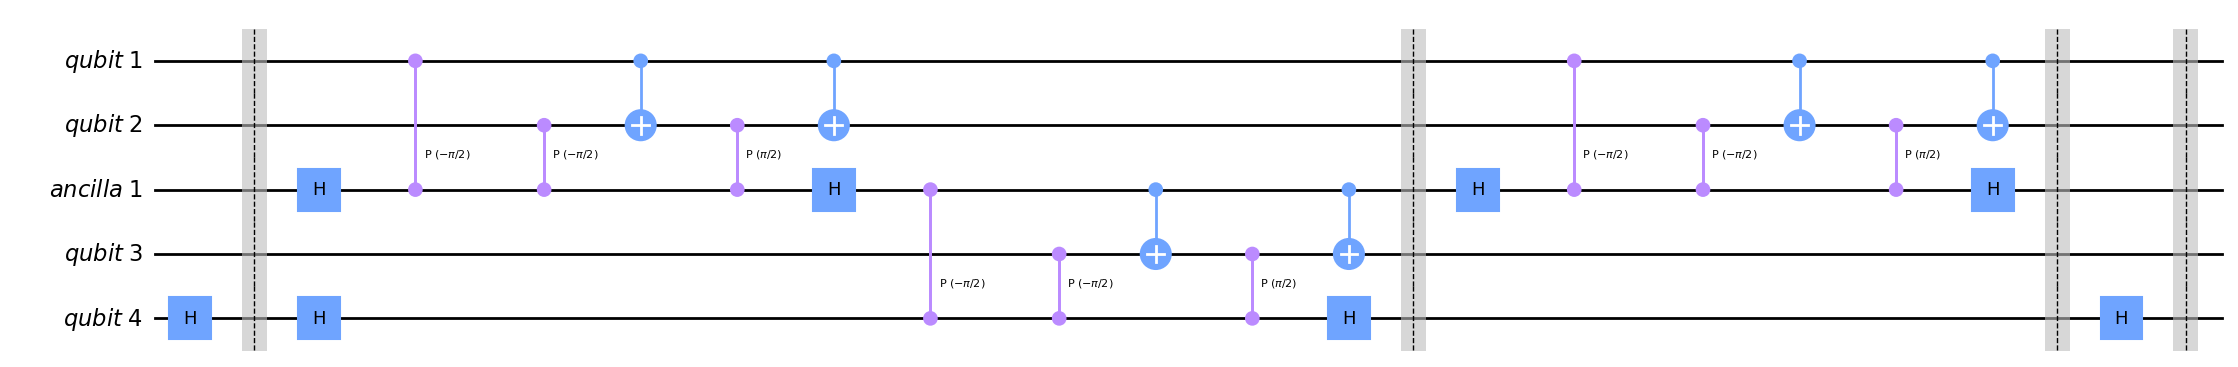

In [11]:
mcz = Qinit(["qubit 1", "qubit 2", "ancilla 1", "qubit 3", "qubit 4"]) + multiCZ
mcz = mcz(backend="qiskit", barriers=True)
mcz.draw("mpl", fold=50)


In [12]:
# Oracle
U_oracle = U_T + Qcycle(mapping=X) + multiCZ + Qcycle(mapping=X) + U_T
# Reflection in the hyperplane orthogonal to |psi> (also called the defusion operator)
U_defuse = U_psi + Qcycle(mapping=X) + multiCZ + Qcycle(mapping=X) + U_psi
# where a cycle of X gates converts the multi-control Z (I - 2|1...1><1...1|) into I - 2|0...0><0...0|

# Grover operator
grover = U_oracle + U_defuse


## Create the circuit for $N$ iterations of Grover's algorithm on $n$ qubits

### Pick an initial state

In [13]:
# Unitary to prepare the initial state |phi>
# Option 1:
# phi = psi (optimal)
# U_phi = Qcycle(mapping=H)
# Option 2:
# possibly with some small orthogonal component to the plane spanned by T and psi
U_phi = Qpivot(
    mapping=H, global_pattern=bin(np.random.randint(0, 2 ** int(n / 4)))[2:].zfill(n)
) + Qcycle(mapping=H)
# Option 3:
# The zero state (suboptimal - large orthogonal component to the plane spanned by T and psi)
# U_phi = Qcycle(mapping=H) + Qcycle(mapping=H)


### Choose the number of iterations

In [14]:
# N_iterations = 3
N_optimal = int((np.pi / 2 / np.arctan(1 / np.sqrt(2**n)) - 1) / 2)
N_iterations = N_optimal


In [15]:
print("Number of qubits:", n)
print("Number of ancillas:", n - 3)
print("Total number of qubits:", 2 * (n) - 3)
print("Search space size:", 2**n)
print("Target state:", target_string, "=", int(target_string, 2))

print("\nInteractions of Grover to perform", N_iterations)
print(
    "Optimal number of iterations",
    N_optimal,
)


Number of qubits: 7
Number of ancillas: 4
Total number of qubits: 11
Search space size: 128
Target state: 0100100 = 36

Interactions of Grover to perform 8
Optimal number of iterations 8


In [16]:
# Name qubits to distinguish between ancillary and query qubits
q_names = [f"q_{i}" if ancilla_str[i] == "0" else f"a_{i}" for i in range(2 * n - 3)]

# Initialise the circuit and prepare the initial state |psi>
groverCircuit = Qinit(q_names) + maskAncillas + U_phi

# Apply Grover N_iterations times
if N_iterations > 0:
    groverCircuit += grover * N_iterations


In [17]:
# Create the circuit using the chose backend and measure all qubits
circuit = groverCircuit(backend="qiskit", barriers=True)
circuit.measure_all()


### Visualize the circuit (if not too big)

In [18]:
if N_iterations < 5:
    fig = circuit.draw("mpl", fold=50)
else:
    fig = None

fig


## Run an experiment

In [19]:
# Run the circuit, get counts
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("qasm_simulator")
job = execute(circuit, backend, shots=1024)
result = job.result()
counts = result.get_counts()


In [20]:
# Post preprocess the results of the Grover algorithm by tracing over ancillary qubits
Q = []
mask = ["q" if n.split("_")[0] == "q" else "a" for n in q_names]
for k in counts.keys():
    Q.append("".join([k[i] if mask[i] == "q" else "*" for i in range(len(k))]))

counts_q = {}
count_keys = counts.keys()
for x in Q:
    n_a = len(x.split("*")) - 1
    # all binary strings of length n_a
    A = [[x for x in bin(i)[2:].zfill(n_a)] + [""] for i in range(2**n_a)]
    Trace_A = []
    for a in A:
        Trace_A.append("".join([x + y for x, y in zip(x.split("*"), a)]))

    counts_q[x.replace("*", "")] = sum([counts[k] for k in Trace_A if k in count_keys])


### Results

Target state: 0100100 = 36

Interactions of Grover performed: 8
Optimal number of iterations: 8

State associate with the 5 largest number of count
['0100100', '1100001', '0111101', '0110111']
Number of counts
[1021, 1, 1, 1]


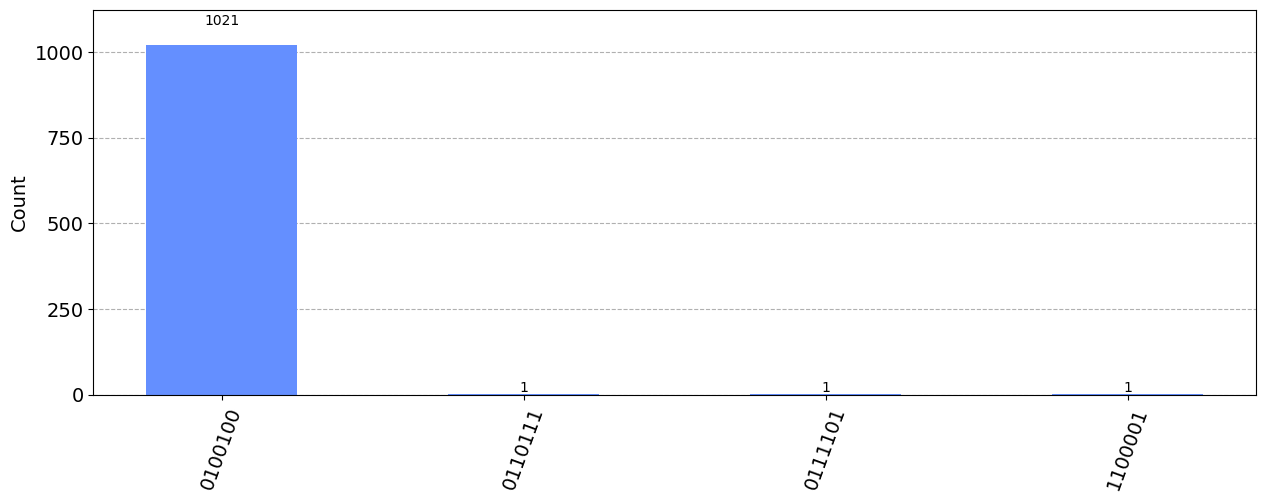

In [21]:
print("Target state:", target_string, "=", int(target_string, 2))

print("\nInteractions of Grover performed:", N_iterations)
print("Optimal number of iterations:", int((np.pi / 2 * np.sqrt(2**n) - 1) / 2))
print()

x = counts_q.keys()
y = counts_q.values()
# States associate with the 5 largest value of y
top_x = [x for _, x in sorted(zip(y, x), reverse=True)][:5]
top_y = sorted(y, reverse=True)[:5]

print("State associate with the 5 largest number of count")
print(top_x)
print("Number of counts")
print(top_y)

plot_histogram(counts_q, figsize=(int(len(x)/4) if len(x)>100 else 15,5))
